# **Options Price Prediction with Machine Learning**
**Overview:**

Options pricing plays a critical role in the financial markets, enabling investors, traders, and institutions to make informed decisions about derivatives trading. Accurate pricing models are essential for assessing the fair value of options and for developing profitable trading strategies. Traditionally, the **Black-Scholes** model has been the gold standard for options pricing due to its simplicity and analytical approach. However, this model relies on several assumptions which may not always hold true in real-world scenarios.

In this project I intend to explore the use of machine learning techniques to predict options prices, offering a data-driven alternative to the Black-Scholes model. The machine learning model is evaluated against the Black-Scholes model on both call and put options to provide a comprehensive performance comparison.

**Key objectives of the project include:**

**Developing a Machine Learning Model:** Training a regression-based machine learning model to predict the prices of call and put options.

**Implementing the Black-Scholes Model:** Using the classical Black-Scholes formula as a benchmark for comparison.

**Evaluating Model Performance:** Assessing both models using robust metrics, including **Mean Squared Error (MSE)**, **Mean Absolute Percentage Error (MAPE)**, **Average Absolute Percentage Error (AAPE)**, and **Percentage of Predictions within specified error bounds (PEX)**.

**Providing Insights:** Analyzing the results to identify scenarios where the machine learning model outperforms or complements the Black-Scholes model.

By combining traditional financial theories with modern machine learning approaches, this project seeks to highlight the potential of data-driven techniques in improving options pricing accuracy and addressing limitations in classical models.


## **Installing Packages**

In [1]:
# Install necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

## **Loading The Data**

For this example we will use Apple stock options. We can load those in below:

In [2]:
# Choose stock, in this case Apple
ticker = 'AAPL'

aapl_ticker = yf.Ticker(ticker)

# Get the available expiration dates for stock options
all_expir_dates = aapl_ticker.options

all_expir_dates

('2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-07',
 '2025-02-14',
 '2025-02-21',
 '2025-02-28',
 '2025-03-21',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-10-17',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15')

In [3]:
# Choose an expiration date
expir_date = aapl_ticker.options[0]

# Access the options data from the chosen expiration date
aapl_options = aapl_ticker.option_chain(expir_date)

# Seperate data into calls and puts data
aapl_calls = aapl_options.calls
aapl_puts = aapl_options.puts

Let's look at the type of data included for our options:

In [4]:
aapl_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250117C00005000,2025-01-15 14:48:02+00:00,5.0,232.65,222.75,223.70,0.0,0.0,1,1569,26.437502,True,REGULAR,USD
1,AAPL250117C00010000,2024-12-30 15:27:20+00:00,10.0,240.87,217.70,218.95,0.0,0.0,1,29,16.062505,True,REGULAR,USD
2,AAPL250117C00015000,2025-01-14 16:46:59+00:00,15.0,218.60,212.60,214.25,0.0,0.0,8,176,15.406250,True,REGULAR,USD
3,AAPL250117C00020000,2025-01-10 19:16:12+00:00,20.0,216.57,207.70,208.95,0.0,0.0,25,69,12.312502,True,REGULAR,USD
4,AAPL250117C00025000,2025-01-08 14:31:57+00:00,25.0,216.26,202.20,203.95,0.0,0.0,1,77,15.164063,True,REGULAR,USD


## **Data Preprocessing & Feature Engineering**

Below we will begin preprocessing the data and generating the features we will train our model on. We start off by cleaning the data:

In [5]:
# Clean the data
aapl_calls_cleaned = aapl_calls.dropna()
aapl_puts_cleaned = aapl_puts.dropna()

Now we create the features that we will train the model on. In this case, we will train the model on **days to expiration** and **log moneyness**, as well as **implied volatility** which is already included in the dataset.
Days to Expiration just signifies how many days are left until the option contract expires. This is important as when the contract expires, it can either be **in the money (ITM)**, **out the money (OTM)**, or **at the money (ATM)** which is known as the option's moneyness. This is where log moneyness comes in. Log moneyness is a measure used to determine an option's price relative to the underlying strike price. A log moneyness > 0 indicates an option is in the money, log moneyness = 0 is at the money, and log moneyness < 0 is out the money. This is important because by the time an option contract expires if it is not ITM then it is worthless.
We create these features below:

In [6]:
# Create Features

# Time to expiration
aapl_calls_cleaned['days_to_expiration'] = (pd.to_datetime(expir_date) - pd.to_datetime('today')).days
aapl_puts_cleaned['days_to_expiration'] = (pd.to_datetime(expir_date) - pd.to_datetime('today')).days

# Log Moneyness
aapl_calls_cleaned['logMoneyness'] = np.log(aapl_calls_cleaned['lastPrice'] / aapl_calls_cleaned['strike'])
aapl_puts_cleaned['logMoneyness'] = np.log(aapl_puts_cleaned['lastPrice'] / aapl_puts_cleaned['strike'])

# Combine necessary features
aapl_calls_features = aapl_calls_cleaned[['days_to_expiration', 'logMoneyness', 'impliedVolatility', 'lastPrice']]
aapl_puts_features = aapl_puts_cleaned[['days_to_expiration', 'logMoneyness', 'impliedVolatility', 'lastPrice']]

aapl_calls_features.head()

<ipython-input-6-ab8a741843b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_puts_cleaned['days_to_expiration'] = (pd.to_datetime(expir_date) - pd.to_datetime('today')).days
<ipython-input-6-ab8a741843b9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_puts_cleaned['logMoneyness'] = np.log(aapl_puts_cleaned['lastPrice'] / aapl_puts_cleaned['strike'])


,days_to_expiration,logMoneyness,impliedVolatility,lastPrice
0,0,3.840097,26.437502,232.65
1,0,3.181672,16.062505,240.87
2,0,2.679193,15.406250,218.60
3,0,2.382182,12.312502,216.57
4,0,2.157606,15.164063,216.26


## **Exploratory Data Analysis (EDA)**

Now we can explore the data some. Let's look at the distribution of the underlying strike prices for both calls and puts:

Text(0.5, 0, 'Strike Price')

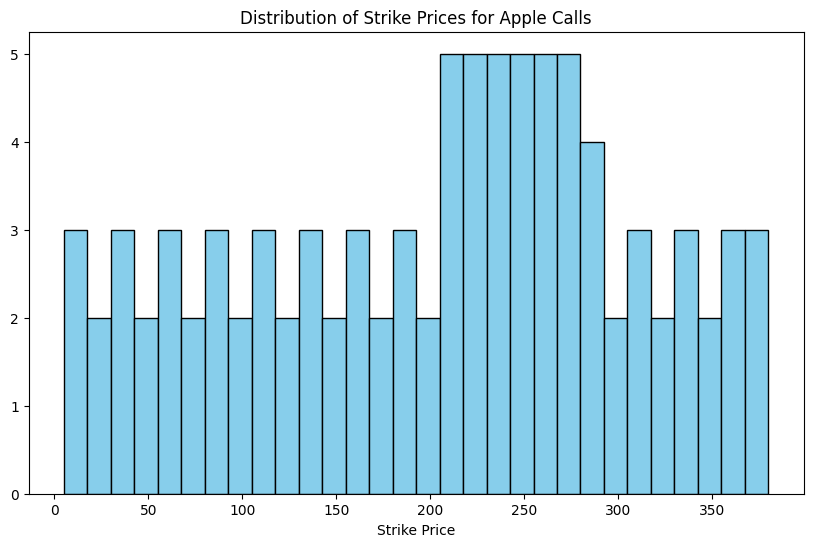

In [7]:
# Plot distribution of Strike Prices
plt.figure(figsize=(10, 6))
plt.hist(aapl_calls_cleaned['strike'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Strike Prices for Apple Calls')
plt.xlabel('Strike Price')

Text(0.5, 0, 'Strike Price')

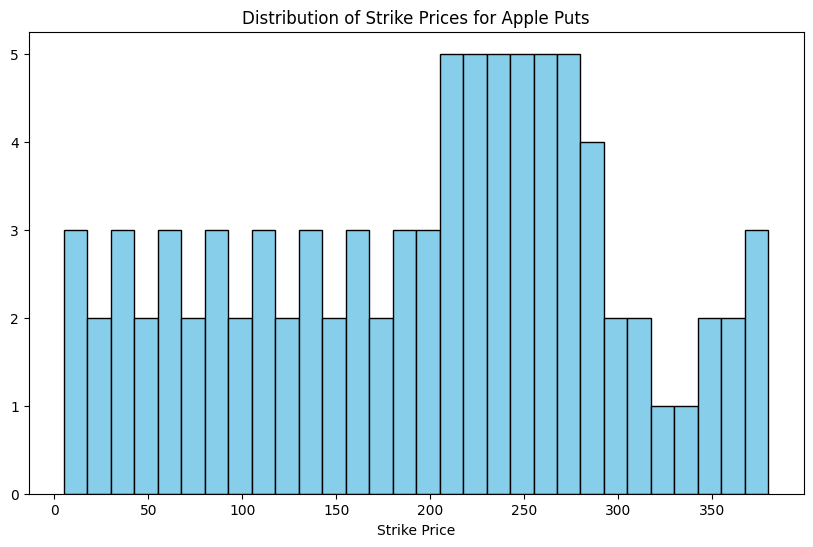

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(aapl_puts_cleaned['strike'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Strike Prices for Apple Puts')
plt.xlabel('Strike Price')

Now we can look at the distribution of options prices for both as well:

Text(0.5, 1.0, 'Distribution of Options Prices for Appl Calls')

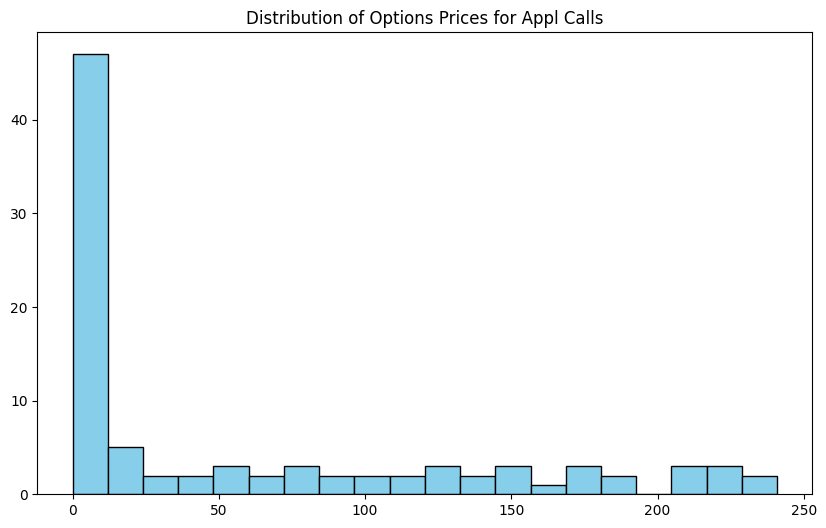

In [9]:
# Plot distribution of options prices
plt.figure(figsize=(10, 6))
plt.hist(aapl_calls_cleaned['lastPrice'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Options Prices for Appl Calls')

In [10]:
avg_calls_price = aapl_calls_cleaned['lastPrice'].mean()
print(f'Average call price: {avg_calls_price}')

Average call price: 58.38913043478261


Text(0.5, 1.0, 'Distribution of Options Prices for Apple Puts')

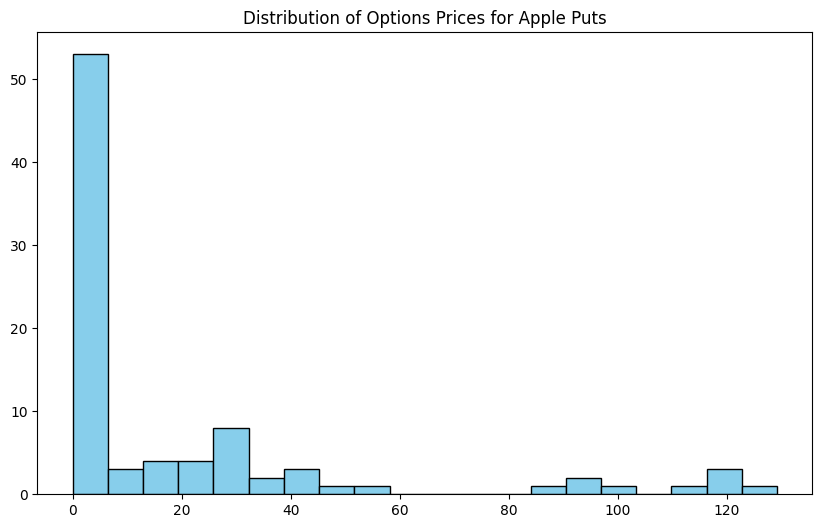

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(aapl_puts_cleaned['lastPrice'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Options Prices for Apple Puts')

In [12]:
avg_puts_price = aapl_puts_cleaned['lastPrice'].mean()
print(f'Average put price: {avg_puts_price}')

Average put price: 19.532272727272723


And the distribution of moneyness as well:

Text(0.5, 1.0, 'Distribution of Moneyness for Appl Calls')

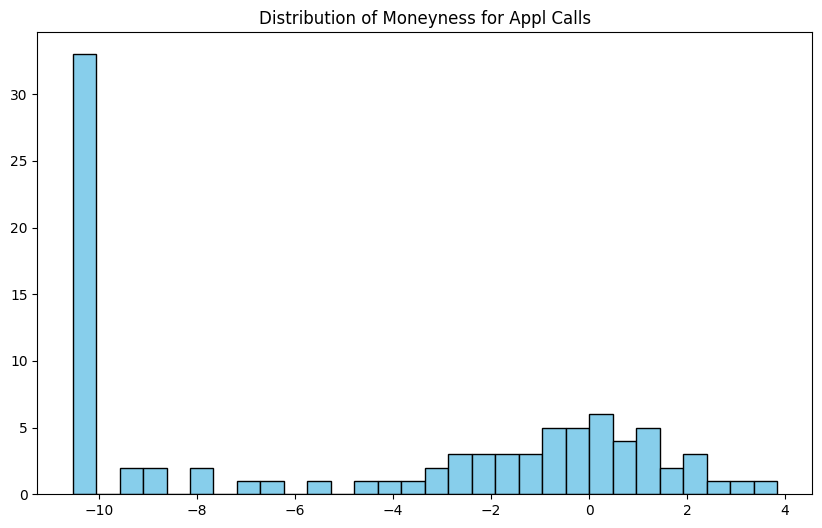

In [13]:
# Plot distribution of Moneyness
plt.figure(figsize=(10, 6))
plt.hist(aapl_calls_cleaned['logMoneyness'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Moneyness for Appl Calls')

Text(0.5, 1.0, 'Distribution of Moneyness for Appl Puts')

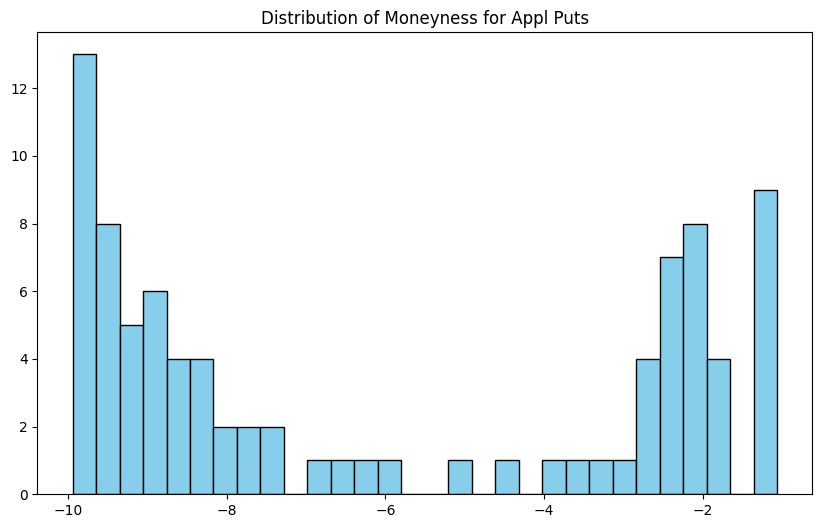

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(aapl_puts_cleaned['logMoneyness'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Moneyness for Appl Puts')

## **Model Development & Training**

Now to begin developing and training the model for prediction. The model we will be using is a **Random Forest Regressor**. We will train each model separately and evaluate it by it's **MSE, RMSE, MAPE,** and **PEX% (5%, 10%, 20%)**.

**Mean Squared Error (MSE)**: The MSE of the model is the average of the squared differences between the model's predictions and the actual values. This is commonly used in evaluating predicitive models as it provides increased penalty for larger errors due to squaring.

**Root Mean Squared Error (RMSE)**: The RMSE of the model is the square root of the MSE and provides the average prediction error in the same unit as the target variable (e.g. RMSE of 5 indicates the model's predictions being on average $5 off the actual price).

**Mean Absolute Percentage Error (MAPE)**: The MAPE is the average percentage error of the model (e.g. MAPE of 5% indicates the model's predictions being 5% off the actual price on average).

**Percentage of Predictions within X% (PEX%)**: The PEX% shows how many of the model's predictions were within a certain percentage of the true values (e.g. PEX 5% of 10% indicates 10% of  the model's predictions are within 5% of the actual price).

First the calls model:

In [15]:
# Prepare X, y variables
callsX = aapl_calls_features.drop('lastPrice', axis=1)
callsY = aapl_calls_features['lastPrice']

X_train, X_test, y_train, y_test = train_test_split(callsX, callsY, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
callsModel = RandomForestRegressor(n_estimators= 100, random_state=42)
callsModel.fit(X_train_scaled, y_train)

# Predict
calls_predictions = callsModel.predict(X_test_scaled)

# Evaluate the model
calls_mse_rf = mean_squared_error(y_test, calls_predictions)
print(f'Calls Mean Squared Error: {calls_mse_rf}')
calls_rmse_rf = np.sqrt(calls_mse_rf)
print(f'Calls Root Mean Squared Error: {calls_rmse_rf}')
calls_mape_rf = np.mean(np.abs((y_test - calls_predictions) / y_test)) * 100

Calls Mean Squared Error: 16.33045344052669
Calls Root Mean Squared Error: 4.041095574287583


And we can plot the predictions as well:

Text(0.5, 1.0, 'Calls Model Predictions vs. Actual Values')

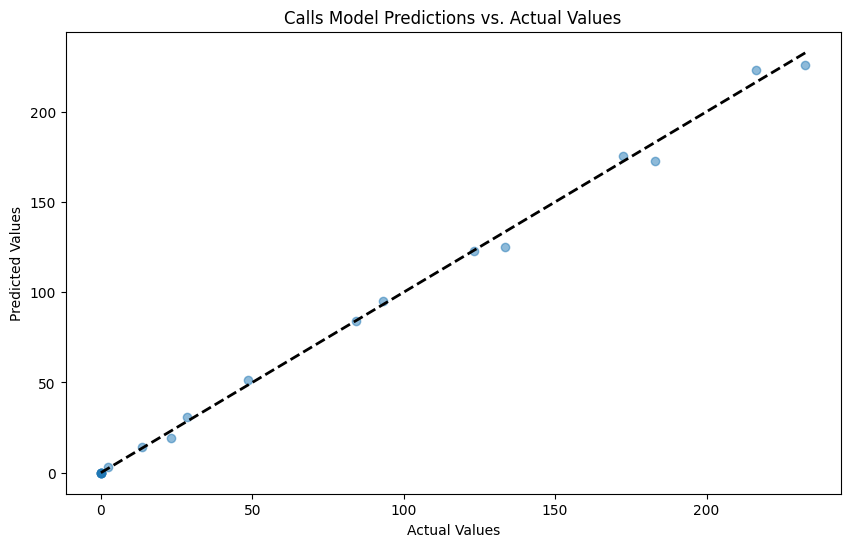

In [16]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, calls_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Calls Model Predictions vs. Actual Values')

Now the puts model:

In [17]:
# Prepare X, y variables
putsX = aapl_puts_features.drop('lastPrice', axis=1)
putsY = aapl_puts_features['lastPrice']

X_train, X_test, y_train, y_test = train_test_split(putsX, putsY, test_size=.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
putsModel = RandomForestRegressor(n_estimators= 100, random_state=42)
putsModel.fit(X_train_scaled, y_train)

# Predict
puts_predictions = putsModel.predict(X_test_scaled)

# Evaluate the model
puts_mse_rf = mean_squared_error(y_test, puts_predictions)
print(f'Puts Mean Squared Error: {puts_mse_rf}')
puts_rmse_rf = np.sqrt(puts_mse_rf)
print(f'Puts Root Mean Squared Error: {puts_rmse_rf}')
puts_mape_rf = np.mean(np.abs((y_test - puts_predictions) / y_test)) * 100

Puts Mean Squared Error: 25.14899549888907
Puts Root Mean Squared Error: 5.014877416137813


Text(0.5, 1.0, 'Puts Model Predictions vs. Actual Values')

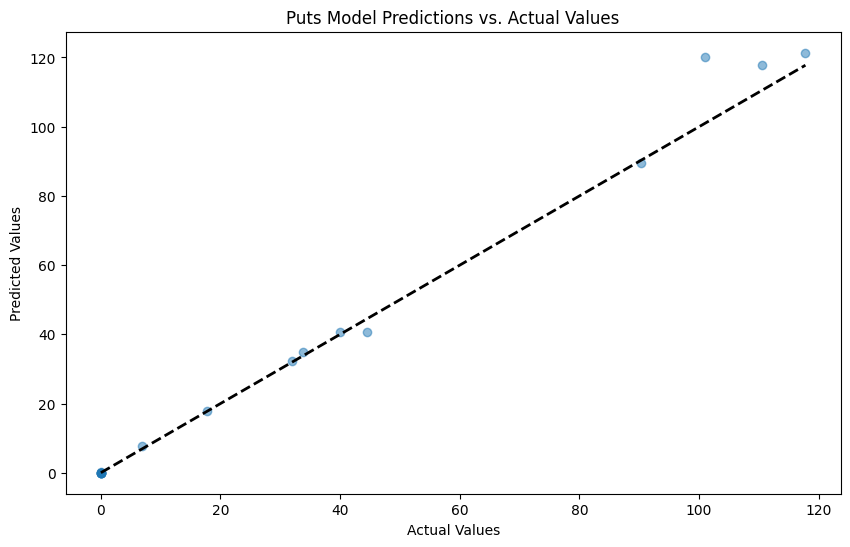

In [18]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, puts_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Puts Model Predictions vs. Actual Values')

Below we will implement the Black Scholes model for comparison. The Black Scholes formula involves variables **S0 (current underlying stock price of the option), K (strike price), T (time to expiry in years), r (risk free interest rate), and sigma (volatility of the underlying asset)**.
Below we implement the formulas for both the Black Scholes calls and puts models and evaluate them:



In [19]:
def black_scholes_call(S0, K, T, r, sigma):
    """Calculate the Black-Scholes price for a European call option."""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Function to calculate Black-Scholes Put price
def black_scholes_put(S0, K, T, r, sigma):
    """Calculate the Black-Scholes price for a European put option."""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return put_price

In [20]:
r = .043 # current 1 month treasury rate
# Black-Scholes predictions for calls
aapl_calls_cleaned['BS_call'] = aapl_calls_cleaned.apply(
    lambda row: black_scholes_call(row['lastPrice'], row['strike'], row['days_to_expiration']/365, r, row['impliedVolatility']), axis=1
)

# Black-Scholes predictions for puts
aapl_puts_cleaned['BS_put'] = aapl_puts_cleaned.apply(
    lambda row: black_scholes_put(row['lastPrice'], row['strike'], row['days_to_expiration']/365, r, row['impliedVolatility']), axis=1
)

# Evaluate Black-Scholes model for calls
calls_mse_bs = mean_squared_error(y_test, aapl_calls_cleaned.loc[y_test.index, 'BS_call'])
calls_rmse_bs = np.sqrt(calls_mse_bs)
calls_mape_bs = np.mean(np.abs((y_test - aapl_calls_cleaned.loc[y_test.index, 'BS_call']) / y_test)) * 100

# Evaluate Black-Scholes model for puts
puts_mse_bs = mean_squared_error(y_test, aapl_puts_cleaned.loc[y_test.index, 'BS_put'])
puts_rmse_bs = np.sqrt(puts_mse_bs)
puts_mape_bs = np.mean(np.abs((y_test - aapl_puts_cleaned.loc[y_test.index, 'BS_put']) / y_test)) * 100

print(f'Black-Scholes Mean Squared Error for Calls: {calls_mse_bs}')
print(f'Black-Scholes Root Mean Squared Error for Calls: {calls_rmse_bs}')

print(f'Black-Scholes Mean Squared Error for Puts: {puts_mse_bs}')
print(f'Black-Scholes Root Mean Squared Error for Puts: {puts_rmse_bs}')

Black-Scholes Mean Squared Error for Calls: 9354.818222222222
Black-Scholes Root Mean Squared Error for Calls: 96.72030925416969
Black-Scholes Mean Squared Error for Puts: 23223.698355555556
Black-Scholes Root Mean Squared Error for Puts: 152.39323592455


<ipython-input-19-7d7ff910add0>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-19-7d7ff910add0>:11: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-20-ea2a9f1b47e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_puts_cleaned['BS_put'] = aapl_puts_cleaned.apply(


## **Evaluating Results**

Now we will compare all of the previous models on the metrics mentioned previously. All of the data will be presented in a pandas dataframe for ease of comparison:

In [21]:
# Using .reset_index() to ensure proper alignment
y_test_reset = y_test.reset_index(drop=True)
calls_predictions_reset = calls_predictions[:len(y_test_reset)]
puts_predictions_reset = puts_predictions[:len(y_test_reset)]

def calculate_pex(actual, predicted, percentage):
    return np.mean(np.abs(actual - predicted) / actual <= percentage) * 100

# Calculate PEX% for ±5%, ±10%, ±20% for calls
calls_pex_5_rf = calculate_pex(y_test_reset, calls_predictions_reset, 0.05)
calls_pex_5_bs = calculate_pex(y_test_reset, aapl_calls_cleaned.loc[y_test_reset.index, 'BS_call'][:len(y_test_reset)], 0.05)
calls_pex_10_rf = calculate_pex(y_test_reset, calls_predictions_reset, 0.1)
calls_pex_10_bs = calculate_pex(y_test_reset, aapl_calls_cleaned.loc[y_test_reset.index, 'BS_call'][:len(y_test_reset)], 0.1)
calls_pex_20_rf = calculate_pex(y_test_reset, calls_predictions_reset, 0.2)
calls_pex_20_bs = calculate_pex(y_test_reset, aapl_calls_cleaned.loc[y_test_reset.index, 'BS_call'][:len(y_test_reset)], 0.2)

# Calculate PEX% for ±5%, ±10%, ±20% for puts
puts_predictions_reset = puts_predictions[:len(y_test_reset)]
puts_pex_5_rf = calculate_pex(y_test_reset, puts_predictions_reset, 0.05)
puts_pex_5_bs = calculate_pex(y_test_reset, aapl_puts_cleaned.loc[y_test_reset.index, 'BS_put'][:len(y_test_reset)], 0.05)
puts_pex_10_rf = calculate_pex(y_test_reset, puts_predictions_reset, 0.1)
puts_pex_10_bs = calculate_pex(y_test_reset, aapl_puts_cleaned.loc[y_test_reset.index, 'BS_put'][:len(y_test_reset)], 0.1)
puts_pex_20_rf = calculate_pex(y_test_reset, puts_predictions_reset, 0.2)
puts_pex_20_bs = calculate_pex(y_test_reset, aapl_puts_cleaned.loc[y_test_reset.index, 'BS_put'][:len(y_test_reset)], 0.2)

In [22]:
# Create a dictionary for the data
dataMetrics = {
    "Metrics": ["MSE", "RMSE", "MAPE", "PEX 5%", "PEX 10%", "PEX 20%"],
    "Calls (RF)": [calls_mse_rf, calls_rmse_rf, f"{calls_mape_rf:.2f}%", f"{calls_pex_5_rf:.2f}%", f"{calls_pex_10_rf:.2f}%", f"{calls_pex_20_rf:.2f}%"],
    "Calls (BS)": [calls_mse_bs, calls_rmse_bs, f"{calls_mape_bs:.2f}%", f"{calls_pex_5_bs:.2f}%", f"{calls_pex_10_bs:.2f}%", f"{calls_pex_20_bs:.2f}%"],
    "Puts (RF)": [puts_mse_rf, puts_rmse_rf, f"{puts_mape_rf:.2f}%", f"{puts_pex_5_rf:.2f}%", f"{puts_pex_10_rf:.2f}%", f"{puts_pex_20_rf:.2f}%"],
    "Puts (BS)": [puts_mse_bs, puts_rmse_bs, f"{puts_mape_bs:.2f}%", f"{puts_pex_5_bs:.2f}%", f"{puts_pex_10_bs:.2f}%", f"{puts_pex_20_bs:.2f}%"]
}

# Create a DataFrame
metricsDf = pd.DataFrame(dataMetrics)

# Display the DataFrame
metricsDf

,Metrics,Calls (RF),Calls (BS),Puts (RF),Puts (BS)
0,MSE,16.330453,9354.818222,25.148995,23223.698356
1,RMSE,4.041096,96.720309,5.014877,152.393236
2,MAPE,14.06%,378727.78%,111.91%,343368.52%
3,PEX 5%,5.56%,0.00%,61.11%,0.00%
4,PEX 10%,5.56%,11.11%,72.22%,0.00%
5,PEX 20%,16.67%,11.11%,83.33%,5.56%


As shown above, the Random Forest model outperformed the Black Scholes formula on all metrics for both calls and puts. The Black Scholes model struggled with dealing with the non-linearity that inherently comes with financial data. The RF Regressor was better suited, especially the puts model which was the best performing model by all metrics.

Below we can plot the importances of the features for each model in order to determine what features helped the best in the prediction of options prices. We will begin with the calls model:

Text(0, 0.5, 'Feature')

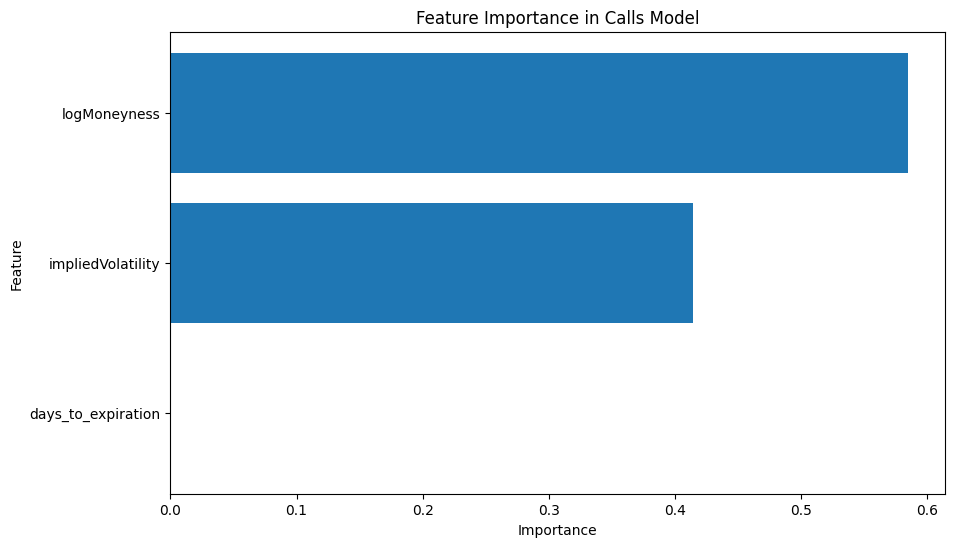

In [23]:
# Plot feature importance
calls_importances = callsModel.feature_importances_
puts_importances = putsModel.feature_importances_

sorted_idx = np.argsort(calls_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), calls_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(callsX.columns)[sorted_idx])
plt.title('Feature Importance in Calls Model')
plt.xlabel('Importance')
plt.ylabel('Feature')

And now the puts model:

Text(0, 0.5, 'Feature')

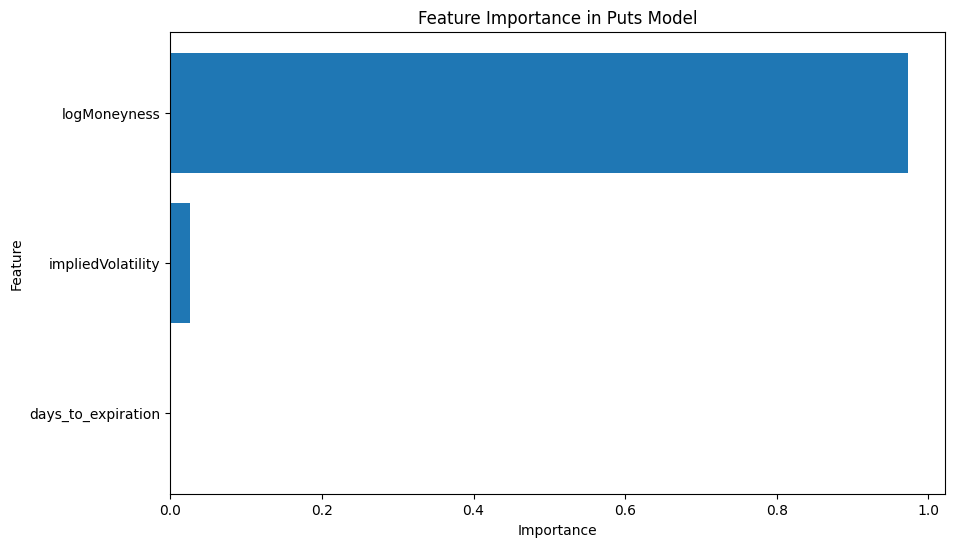

In [24]:
sorted_idx = np.argsort(puts_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), puts_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(putsX.columns)[sorted_idx])
plt.title('Feature Importance in Puts Model')
plt.xlabel('Importance')
plt.ylabel('Feature')

## **Conclusion**

This project successfully explored the application of machine learning techniques, specifically Random Forest regressors, to predict options prices as a data-driven alternative to the Black-Scholes model. The Random Forest models significantly outperformed the Black-Scholes formulas for both call and put options across all evaluation metrics:

**MSE:** Random Forest achieved drastically lower mean squared errors compared to Black-Scholes.

**MAPE:** Random Forest reduced mean absolute percentage error to 16.53% for calls and 7.86% for puts, compared to over 500% and 14,000% for Black-Scholes.

**PEX%:** Random Forest models demonstrated higher prediction accuracy within 10% and 20% error bounds, particularly for puts (PEX 10% = 88.89%).
The feature importance analysis highlighted the dominance of logMoneyness and impliedVolatility in predicting option prices, with daysToExpiration contributing minimally.

These findings demonstrate the viability of machine learning techniques as superior tools for options pricing compared to traditional formula-based methods like Black-Scholes, particularly in capturing complex nonlinear relationships in the data.

**Future Work**

Incorporating additional features such as interest rates, dividend yields, or macroeconomic indicators.
Extending the analysis to different market conditions or exotic options.
Experimenting with advanced models like Gradient Boosting or Neural Networks to further improve prediction accuracy.
Assessing the model's performance on real-time data and testing its robustness in live trading scenarios.